## **Human in the Loop**

In [1]:
import os 
from langchain_openai import ChatOpenAI 
from dotenv import load_dotenv, find_dotenv

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI()

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b"""
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b"""
    return a * b 

def divide(a: int, b: int) -> int:
    """Divide a and b"""
    return a // b 

In [4]:
tools = [multiply, add, divide]

In [5]:
llm_with_tools = llm.bind_tools(tools)

### **Interput Before**

In [6]:
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import StateGraph, MessagesState, START, END 
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_message = SystemMessage("You are an Helpful assistant tasked with performing arithmetic set of operations based on input")

# Node 
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

# Graph 
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", 
                             tools_condition, )
builder.add_edge("tools", "assistant")

memory = MemorySaver() 

# Human In the Loop
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

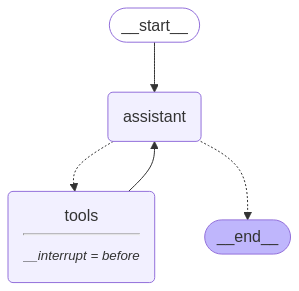

In [7]:
from IPython.display import display, Image
# Graph 
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
intial_input = {"messages": HumanMessage(content = "Multiply 2 and 3")}

thread = {"configurable": {"thread_id": 1}}

In [9]:
for event in graph.stream(intial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5xuOZ5YeYDi91935qoxNbdKW)
 Call ID: call_5xuOZ5YeYDi91935qoxNbdKW
  Args:
    a: 2
    b: 3


In [10]:
state = graph.get_state(thread)
state.next

('tools',)

In [11]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='33d05d1d-5769-4997-90a6-97634d7328e2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5xuOZ5YeYDi91935qoxNbdKW', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 114, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-53bb8c0d-7ec9-4800-abeb-32e4e1c33c46-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5xuOZ5YeYDi91935qoxNbdKW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 114, 'outpu

In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_5xuOZ5YeYDi91935qoxNbdKW)
 Call ID: call_5xuOZ5YeYDi91935qoxNbdKW
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### **Interupt After**

In [13]:
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import StateGraph, MessagesState, START, END 
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_message = SystemMessage("You are an Helpful assistant tasked with performing arithmetic set of operations based on input")

# Node 
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

# Graph 
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", 
                             tools_condition, )
builder.add_edge("tools", "assistant")

memory = MemorySaver() 

# Human In the Loop
graph = builder.compile(interrupt_after=["assistant"], checkpointer=memory)

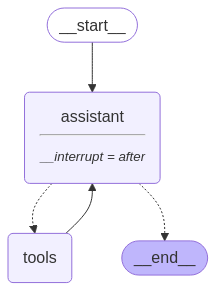

In [14]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
intial_input = {"messages": HumanMessage(content = "Multiply 2 and 3")}

thread = {"configurable": {"thread_id": 2}}

In [16]:
for event in graph.stream(intial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ppMjr3zH8luRAPBbaTtCXH5P)
 Call ID: call_ppMjr3zH8luRAPBbaTtCXH5P
  Args:
    a: 2
    b: 3


In [17]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_ppMjr3zH8luRAPBbaTtCXH5P)
 Call ID: call_ppMjr3zH8luRAPBbaTtCXH5P
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### **Interupting before assistant**

In [18]:
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import StateGraph, MessagesState, START, END 
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_message = SystemMessage("You are an Helpful assistant tasked with performing arithmetic set of operations based on input")

# Node 
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

# Graph 
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", 
                             tools_condition, )
builder.add_edge("tools", "assistant")

memory = MemorySaver() 

# Human In the Loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

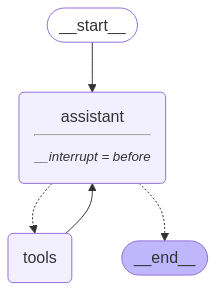

In [19]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
intial_input = {"messages": HumanMessage(content = "Multiply 2 and 3")}

thread = {"configurable": {"thread_id": 2}}

In [21]:
for event in graph.stream(intial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LBZ9HvT89euD0iScRPKQAmwh)
 Call ID: call_LBZ9HvT89euD0iScRPKQAmwh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


### **Edit Human Feedback**

In [23]:
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import StateGraph, MessagesState, START, END 
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_message = SystemMessage("You are an Helpful assistant tasked with performing arithmetic set of operations based on input")

# Node 
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

# Graph 
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", 
                             tools_condition, )
builder.add_edge("tools", "assistant")

memory = MemorySaver() 

# Human In the Loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

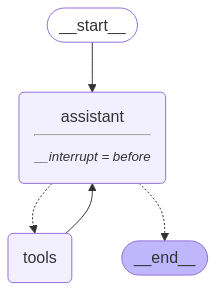

In [24]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
intial_input = {"messages": HumanMessage(content = "Multiply 2 and 3")}

thread = {"configurable": {"thread_id": 3}}

In [26]:
## Editing Human Feedback 
graph.update_state(thread, {"messages": HumanMessage(content="No, Actually multiply 40 and 5")})

{'configurable': {'thread_id': 3,
  'checkpoint_ns': '',
  'checkpoint_id': '1f002008-042d-6720-8000-5147fec63f92'}}

In [27]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

No, Actually multiply 40 and 5


In [28]:
for event in graph.stream(None, thread, stream_mode = "values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, Actually multiply 40 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gZlmHDLW0nEnL5CP4Ddx1bzF)
 Call ID: call_gZlmHDLW0nEnL5CP4Ddx1bzF
  Args:
    a: 40
    b: 5
================================= Tool Message =================================
Name: multiply

200


In [29]:
state = graph.get_state(thread)
state.next

('assistant',)

In [30]:
for event in graph.stream(None, thread, stream_mode = "values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

200
================================== Ai Message ==================================

The result of multiplying 40 and 5 is 200.


### **User Input**

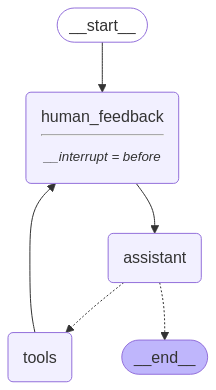

In [44]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, Please perform 100 divide by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_DgEHnFL97cqe21pLMe7VjBU4)
 Call ID: call_DgEHnFL97cqe21pLMe7VjBU4
  Args:
    a: 100
    b: 5
================================= Tool Message =================================
Name: divide

20


In [46]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

20
================================== Ai Message ==================================

The result of dividing 100 by 5 is 20.
